# Goal:
Here, I try to build a XGBoost model to predict an individual's mental health based on the data on health risk behaviors, chronic diseases and conditions, access to health care, and use of preventive health services related to the leading causes of death and disability in the United States, which was downloaded from the CDC(Center of Disease Control and Prevention) website.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## read the data

In [34]:
import pickle
df = pickle.load( open( "df_cdc", "rb" ) )
print('The number of records:',df.shape[0])
print('The number of variables:',df.shape[1])
df.head()

The number of records: 437436
The number of variables: 275


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_MAM5022,_RFPAP34,_RFPSA22,_RFBLDS3,_COL10YR,_HFOB3YR,_FS5YR,_FOBTFS,_CRCREC,_AIDTST3
0,1.0,1.0,01052018,01,05,2018,1100.0,2018000001,2.018000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,1.0,1.0,01122018,01,12,2018,1100.0,2018000002,2.018000e+09,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,1.0,1.0,01082018,01,08,2018,1100.0,2018000003,2.018000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,1.0,1.0,01032018,01,03,2018,1100.0,2018000004,2.018000e+09,1.0,...,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1.0,1.0,01122018,01,12,2018,1100.0,2018000005,2.018000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [35]:
df.columns

Index(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'CTELENM1',
       ...
       '_MAM5022', '_RFPAP34', '_RFPSA22', '_RFBLDS3', '_COL10YR', '_HFOB3YR',
       '_FS5YR', '_FOBTFS', '_CRCREC', '_AIDTST3'],
      dtype='object', length=275)

The variable names are difficult to be interpreted. I downloaded the pdf description file to translate the variable codes.

In [36]:

import docx2txt
 
# read in word file. This one contains the explanations of all columns
result = docx2txt.process("C:/Users/XIANY/codebook18_llcp-v2-508.docx")


In [37]:
for i in range(50,65):
    
    print(result.split('\n')[i])
 

Label: State FIPS Code

Section Name: Record Identification

Section Number: 0

Question Number: 1

Column: 1-2

Type of Variable: Num

SAS Variable Name: _STATE

Question Prologue: Question:  State FIPS Code


### read pdf file and transform the text into a table of the column information

In [38]:

Label=[]
SectionName=[]
SectionNumber=[]
QuestionNumber=[]
Column=[]
TypeofVariable=[]
SASVariableName=[]
QuestionPrologue=[]
Question=[]
for i in range(len(result.split('\n'))):
    #print(result.split('\n')[i])
    text=result.split('\n')[i]
    if 'Label:' in text:
        Label.append(result.split('\n')[i].split('Label: ')[1].split('Section Name')[0])
    if 'Section Name:' in text:
        SectionName.append(result.split('\n')[i].split('Section Name:')[1]
                           .split('Section Number:')[0].split(' Module')[0].split(' Core')[0].lstrip(' ').rstrip(' '))
    if 'Section Number:' in text:
        SectionNumber.append(result.split('\n')[i].split('Section Number:')[1].split('Question Number:')[0])
    if 'Question Number:' in text:
        QuestionNumber.append(result.split('\n')[i].split('Question Number:')[1].split('Column:')[0])
    if 'Column:' in text:
        Column.append(result.split('\n')[i].split('Column:')[1].split('Type of Variable:')[0])
    if 'Type of Variable:' in text:
        TypeofVariable.append(result.split('\n')[i].split('Type of Variable:')[1].split('SAS Variable Name:')[0])
    if 'SAS Variable Name:' in text:
        SASVariableName.append(result.split('\n')[i].split('SAS Variable Name:')[1].split('Question Prologue:')[0])
    if 'Question Prologue:' in text:
        QuestionPrologue.append(result.split('\n')[i].split('Question Prologue:')[1].split('Question:')[0])
    if 'Question:' in text:
        Question.append(result.split('\n')[i].split('Question:')[1].split('Value')[0])
print(len(Label))
print(len(SectionName))
print(len(SectionNumber))
print(len(QuestionNumber))
print(len(Column))
print(len(TypeofVariable))
print(len(SASVariableName))
print(len(QuestionPrologue))
print(len(Question))

277
277
277
277
277
277
277
277
277


In [39]:
df=pd.DataFrame()
df['Label']=Label
df['SectionName']=SectionName
df['SectionNumber']=SectionNumber
df['QuestionNumber']=QuestionNumber
df['Column']=Column
df['TypeofVariable']=TypeofVariable
df['SASVariableName']=SASVariableName
df['QuestionPrologue']=QuestionPrologue
df['Question']=Question
df_record=df.drop_duplicates().reset_index()
df_record.shape

(273, 10)

In [40]:
df_record.iloc[10:15,:]

,index,Label,SectionName,SectionNumber,QuestionNumber,Column,TypeofVariable,SASVariableName,QuestionPrologue,Question
10,12,Private Residence?,Land Line Introduction,0,2,64,Num,PVTRESD1,Variable only on the land line survey,\tIs this a private residence?\t[READ ONLY IF ...
11,13,Do you live in college housing?,Land Line Introduction,0,3,65,Num,COLGHOUS,Variable only on the land line survey,Do you live in college housing?
12,14,Resident of State,Land Line Introduction,0,4,66,Num,STATERE1,Variable only on the land line survey,Do you currently live in \t(state) \t?
13,15,Cellular Telephone,Land Line Introduction,0,5,67,Num,CELLFON4,Variable only on the land line survey,\tIs this a cell telephone?\t(Telephone servic...
14,16,Are you 18 years of age or older?,Land Line Introduction,0,6,68,Num,LADULT,Variable only on the land line survey,Are you 18 years of age or older?


### remove the variables may causing prediction leakage

Among all the variables, there are some variables directly linked to the mental health status, such as this question: During the past 30 days, for about how many days did poor physical or mental health keep you from doing your usual activities, such as self-care, work, or recreation?

I want to remove these variables causing data leakage.

In [41]:
##list the variable group name.(i.e. Each group contain several behavior variables)
pd.set_option('display.max_rows', None)
df_record
np.unique(df_record['SectionName'])

array(['Adult Human Papillomavirus (HPV) - Vaccination',
       'Alcohol Consumption', 'Breast and Cervical Cancer Screening',
       'Calculated Race Variables', 'Calculated Variables',
       'Cancer Survivorship', 'Caregiver', 'Cell Phone Introduction',
       'Child Demographic Variables', 'Child Weighting Variables',
       'Childhood Asthma Prevalence', 'Chronic Health Conditions',
       'Clinic Breast Exam', 'Cognitive Decline',
       'Colorectal Cancer Screening', 'Demographics',
       'Depression and Anxiety', 'Diabetes', 'E-Cigarettes',
       'Excess Sun Exposure', 'Exercise', 'Falls', 'HIV/AIDS',
       'Health Care Access', 'Health Status',
       'Healthy Days — Health Related Quality of Life', 'Immunization',
       'Inadequate Sleep', 'Indoor Tanning', 'Land Line Introduction',
       'Lung Cancer Screening', 'Marijuana Use', 'Oral Health',
       'Pre-Diabetes', 'Prostate Cancer Screening',
       'Prostate Cancer Screening Decision Making',
       'Questionnaire La

In [42]:
##choose variables will be used for predicting mental health
np.unique(df_record['SectionName'])
chosenVairable=df_record[(df_record['SectionName'].isin(['Adult Human Papillomavirus (HPV) - Vaccination',
       'Alcohol Consumption', 'Breast and Cervical Cancer Screening',
       'Calculated Race Variables', 'Calculated Variables',
       'Cancer Survivorship', 'Caregiver', 'Cell Phone Introduction',
       'Child Demographic Variables', 'Child Weighting Variables',
       'Childhood Asthma Prevalence', 'Chronic Health Conditions',
       'Clinic Breast Exam', 'Cognitive Decline',
       'Colorectal Cancer Screening', 'Demographics',
       'Depression and Anxiety', 'Diabetes', 'E-Cigarettes',
       'Excess Sun Exposure', 'Exercise', 'Falls', 'HIV/AIDS',
       'Health Care Access', #'Health Status',
       #'Healthy Days — Health Related Quality of Life',
       'Immunization',
       'Inadequate Sleep', 'Indoor Tanning', 'Land Line Introduction',
       'Lung Cancer Screening', 'Marijuana Use', 'Oral Health',
       'Pre-Diabetes', 'Prostate Cancer Screening',
       'Prostate Cancer Screening Decision Making',
       #'Questionnaire Language', 'Questionnaire Version',
       'Random Child Selection', #'Record Identification',
       'Respiratory Health (COPD Symptoms)',
       'Seatbelt Use and Drinking and Driving',
       'Sexual Orientation and Gender Identity',
       'Shingles (ZOSTAVAX or ZOS)', 'Sleep Disorder',
       'Tetanus Diphtheria (Tdap) (Adults)', 'Tobacco Use', 'Urban Rural'#,'Weighting Variables'
                                                        ]))]['SASVariableName']

In [43]:
#import xport
#with open('C:/Users/XIANY/LLCP2018.XPT', 'rb') as f:
#    df = xport.to_dataframe(f)
#import pandas as pd
##https://www.cdc.gov/brfss/annual_data/annual_2018.html
#pd.set_option('display.max_columns', None)
#df.head()
#df.shape

In [44]:
# Save a dictionary into a pickle file.
#import pickle

#pickle.dump( df, open( "df_cdc", "wb" ) )

In [48]:
import pickle
df = pickle.load( open( "df_cdc", "rb" ) )
new_df=df[[i.lstrip(' ').rstrip(' ') for i in list(chosenVairable.values)]].copy()
new_df.shape
#df[[list(chosenVairable.values)]]

(437436, 248)

In [49]:
new_df.head()

,CTELENM1,PVTRESD1,COLGHOUS,STATERE1,CELLFON4,LADULT,NUMADULT,NUMMEN,NUMWOMEN,SAFETIME,...,_MAM5022,_RFPAP34,_RFPSA22,_RFBLDS3,_COL10YR,_HFOB3YR,_FS5YR,_FOBTFS,_CRCREC,_AIDTST3
0,1.0,1.0,NaN,1.0,2.0,NaN,1.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,1.0,1.0,NaN,1.0,2.0,NaN,1.0,0.0,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,1.0,1.0,NaN,1.0,2.0,NaN,1.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,1.0,1.0,NaN,1.0,2.0,NaN,1.0,1.0,0.0,NaN,...,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1.0,1.0,NaN,1.0,2.0,NaN,2.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


All individuals with 0 days of depression in the last 30 days were considered as mental healthy, while individuals with depression in the last 30 days were considered as mental unhealthy.

In [50]:
variable='MENTHLTH' 
new_df[variable]=df[variable].copy()
new_df['PHYSHLTH']=df['PHYSHLTH'].copy()
  
new_df = new_df[new_df[variable]<=88]
new_df = new_df[new_df[variable]!=77]
new_df=new_df.fillna(-1)
new_df=new_df.drop(['DLYOTHER'],axis=1)
new_df=new_df.drop(['DECIDE'],axis=1)
new_df=new_df.drop(['ADDEPEV2'],axis=1)
new_df=new_df.drop(['_MENT14D'],axis=1)
new_df=new_df.drop(['DIFFALON'],axis=1)

 

#phone number

new_df.shape
#new_df=new_df.drop(['GENHLTH'],axis=1)

(430423, 245)

## data preparation

### mean encoding( This helps to turn the category data into numerical data which improves the performance of the model)

In [51]:
#pip install xgboost
def Mean_encoding(X_train,X_val,Y):
    temp=X_train.copy()
    temp['target']=Y.copy()
    temp2_train=temp.copy()
    temp2_val=X_val.copy()
    for i in X.columns:
        if len(np.unique(X[i]))<100:
            mean_map=temp.groupby([i]).target.mean()
            mean_map=pd.DataFrame(mean_map).reset_index()
            mean_map=mean_map.rename({'target':(i+'mean')},axis='columns')
            temp2_train=temp2_train.merge(mean_map,how='left')
            temp2_train=temp2_train.drop([i],axis=1)
            temp2_val=temp2_val.merge(mean_map,how='left')
            temp2_val=temp2_val.drop([i],axis=1)
            print(i)
    temp2_train=temp2_train.drop(['target'],axis=1)
    return temp2_train,temp2_val
        


In [52]:
def Mean_encoding2(X_train,X_val,Y):
    temp=X_train.copy()
    temp['target']=Y.copy()
    temp2_train=temp.copy()
    temp2_val=X_val.copy()
    for i in X.columns:
        if len(np.unique(X[i]))<=10:
            mean_map=temp.groupby([i]).target.mean()
            mean_map=pd.DataFrame(mean_map).reset_index()
            mean_map=mean_map.rename({'target':(i+'mean')},axis='columns')
            temp2_train=temp2_train.merge(mean_map,how='left')
            temp2_train=temp2_train.drop([i],axis=1)
            temp2_val=temp2_val.merge(mean_map,how='left')
            temp2_val=temp2_val.drop([i],axis=1)
    
            print(i)#do mean encoding
        else:
            #print(np.sort(np.unique(X[i]))[-10:])
            #print(np.sort(np.unique(X[i]))[-3:])
            #print(i)
            if sum([i in [77,88,99] for i in np.sort(np.unique(X[i]))[-3:] ])>=2:
                print('do 789')
                temp2_train[i][temp2_train[i]==88]=0
                temp2_train[i][temp2_train[i]==77]=-1
                temp2_train[i][temp2_train[i]==99]=-1
                temp2_val[i][temp2_val[i]==88]=0
                temp2_val[i][temp2_val[i]==77]=-1
                temp2_val[i][temp2_val[i]==99]=-1
            elif sum([i in [777,888,999] for i in np.sort(np.unique(X[i]))[-3:] ])>=2:
                temp2_train[i][temp2_train[i]==888]=0
                temp2_train[i][temp2_train[i]==777]=-1
                temp2_train[i][temp2_train[i]==999]=-1
                temp2_val[i][temp2_val[i]==888]=0
                temp2_val[i][temp2_val[i]==777]=-1
                temp2_val[i][temp2_val[i]==999]=-1
                print('do 789')
            elif sum([i in [777777,888888,999999] for i in np.sort(np.unique(X[i]))[-3:] ])>=2:
                temp2_train[i][temp2_train[i]==888888]=0
                temp2_train[i][temp2_train[i]==777777]=-1
                temp2_train[i][temp2_train[i]==999999]=-1
                temp2_val[i][temp2_val[i]==888888]=0
                temp2_val[i][temp2_val[i]==777777]=-1
                temp2_val[i][temp2_val[i]==999999]=-1
                print('do 789')
            
    temp2_train=temp2_train.drop(['target'],axis=1)
    return temp2_train,temp2_val
              

### split train and test set

In [53]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
Y=new_df[variable].copy()

Y[Y==88]=0
X=new_df.drop([variable], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, Y,  
    test_size=0.7, random_state=42)
X_train,X_val=Mean_encoding2(X_train,X_val,Y)
y_train[y_train>0]=1
y_val[y_val>0]=1
X.head()

CTELENM1
PVTRESD1
COLGHOUS
STATERE1
CELLFON4
LADULT
SAFETIME
CTELNUM1
CELLFON5
CADULT
PVTRESD3
CCLGHOUS
CSTATE1
LANDLINE
do 789
HLTHPLN1
PERSDOC2
MEDCOST
CHECKUP1
EXERANY2
do 789
CVDINFR4
CVDCRHD4
CVDSTRK3
ASTHMA3
ASTHNOW
CHCSCNCR
CHCOCNCR
CHCCOPD1
HAVARTH3
CHCKDNY1
DIABETE3
LASTDEN4
RMVTETH4
SEX1
MARITAL
EDUCA
RENTHOM1
NUMHHOL3
NUMPHON3
CPDEMO1B
VETERAN3
EMPLOY1
do 789
do 789
PREGNANT
DEAF
BLIND
DIFFWALK
DIFFDRES
SMOKE100
SMOKDAY2
STOPSMK2
do 789
USENOW3
do 789
do 789
do 789
do 789
FLUSHOT6
do 789
do 789
PNEUVAC4
do 789
do 789
SEATBELT
do 789
HADMAM
HOWLONG
HADPAP2
LASTPAP2
HPVTEST
HPLSTTST
HADHYST2
PCPSAAD3
PCPSADI1
PCPSARE1
PSATEST1
PSATIME
PCPSARS1
BLDSTOOL
LSTBLDS3
HADSIGM3
HADSGCO1
LASTSIG3
HIVTST6
do 789
HIVRISK5
PDIABTST
PREDIAB1
INSULIN
do 789
do 789
do 789
do 789
EYEEXAM1
DIABEYE
DIABEDU
MEDICARE
do 789
DELAYME1
NOCOV121
LSTCOVRG
do 789
MEDSCOS1
CARERCVD
MEDBILL1
CIMEMLOS
CDHOUSE
CDASSIST
CDHELP
CDSOCIAL
CDDISCUS
CAREGIV1
do 789
CRGVLNG1
CRGVHRS1
do 789
CRGVPERS
CRGVHOUS
CRGV

,CTELENM1,PVTRESD1,COLGHOUS,STATERE1,CELLFON4,LADULT,NUMADULT,NUMMEN,NUMWOMEN,SAFETIME,...,_RFPAP34,_RFPSA22,_RFBLDS3,_COL10YR,_HFOB3YR,_FS5YR,_FOBTFS,_CRCREC,_AIDTST3,PHYSHLTH
0,1.0,1.0,-1.0,1.0,2.0,-1.0,1.0,0.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,30.0
1,1.0,1.0,-1.0,1.0,2.0,-1.0,1.0,0.0,1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,88.0
2,1.0,1.0,-1.0,1.0,2.0,-1.0,1.0,0.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,10.0
3,1.0,1.0,-1.0,1.0,2.0,-1.0,1.0,1.0,0.0,-1.0,...,-1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,88.0
4,1.0,1.0,-1.0,1.0,2.0,-1.0,2.0,1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,88.0


In [54]:
#baseline
#len(Y[Y==0])/len(Y)
#np.unique(Y)
#X_train.head()

## Apply xgboost, a tree based model

In [55]:
params = {
        'min_child_weight': [1, 5],
        'gamma': [1, 1.5, 2],
        'subsample': [0.4, 0.6, 0.8],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5,10,20]
        }
gb_clf = XGBClassifier(learning_rate=0.1, n_estimators=600,
                    silent=False, nthread=1)

### hyperparameter tunning

In [60]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
folds = 2
param_comb = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(gb_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
 # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
 # timing ends here for "start_time" variable

NameError: name 'params' is not defined

In [20]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([660.3858037 , 844.2461493 , 407.25318074]), 'std_fit_time': array([1.51489401, 0.78550887, 0.2408967 ]), 'mean_score_time': array([3.45801532, 3.48488557, 2.25674546]), 'std_score_time': array([0.15668786, 0.07903802, 0.24682391]), 'param_subsample': masked_array(data=[0.6, 0.6, 0.8],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 5, 5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[5, 5, 5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[1.5, 1, 1],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_colsample_bytree': masked_array(data=[0.6, 1.0, 0.8],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params':

### training the data

In [56]:
gb_clf = XGBClassifier(subsample= 0.6, min_child_weight= 1, max_depth=6, gamma= 1.5, colsample_bytree= 0.8,scale_pos_weight = 1,
                      max_delta_step=10,objective= 'binary:logistic') #GradientBoostingClassifier(n_estimators=20, learning_rate=1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train)
#print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))

Accuracy score (training): 0.761
Accuracy score (validation): 0.742


### examing the accuracy

In [57]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_val, gb_clf.predict(X_val)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", acc_)
# Sensitivity : 
sens_ = tp / (tp + fn)
print("Sensitivity  : ", sens_)
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", sp_)
# False positive rate (FPR)
FPR = fp / (tn + fp)
print("False positive rate  : ", FPR)

Error rate  :  0.2578452490399838
Accuracy  :  0.7421547509600162
Sensitivity  :  0.42942821659716685
Specificity  :  0.8952911162091607
False positive rate  :  0.10470888379083933


### prediction accuracy for those people has mental issue (all, more than 7 days in the last month, more than 14 days in the last month,more than 28 days in the last month)

In [58]:
_, _, _, y_val = train_test_split(X, Y,  
    test_size=0.7, random_state=42)
y_val_temp=y_val.copy()
y_val[y_val>0]=1
for i in [0,7,14,28]:
    

    X_temp=X_val.iloc[np.where(y_val_temp>i)[0],:]
    y_temp=y_val[y_val_temp>i]
    print(gb_clf.score(X_temp, y_temp))

0.42942821659716685
0.5627917364600782
0.593131776858256
0.6009846576597206


This model has a 90% chance to correctly label a mentally healthy person, and 43% chance to detect a mentally unhealthy person. The accuracy increases with the severity of mental issues.

### check the important factors

In [59]:
#troubleshooting
X_temp=X_val.iloc[np.where(y_val_temp>14)[0],:]
y_temp=y_val[y_val_temp>14]
seq=np.where((gb_clf.predict(X_temp)-y_temp)==-1)

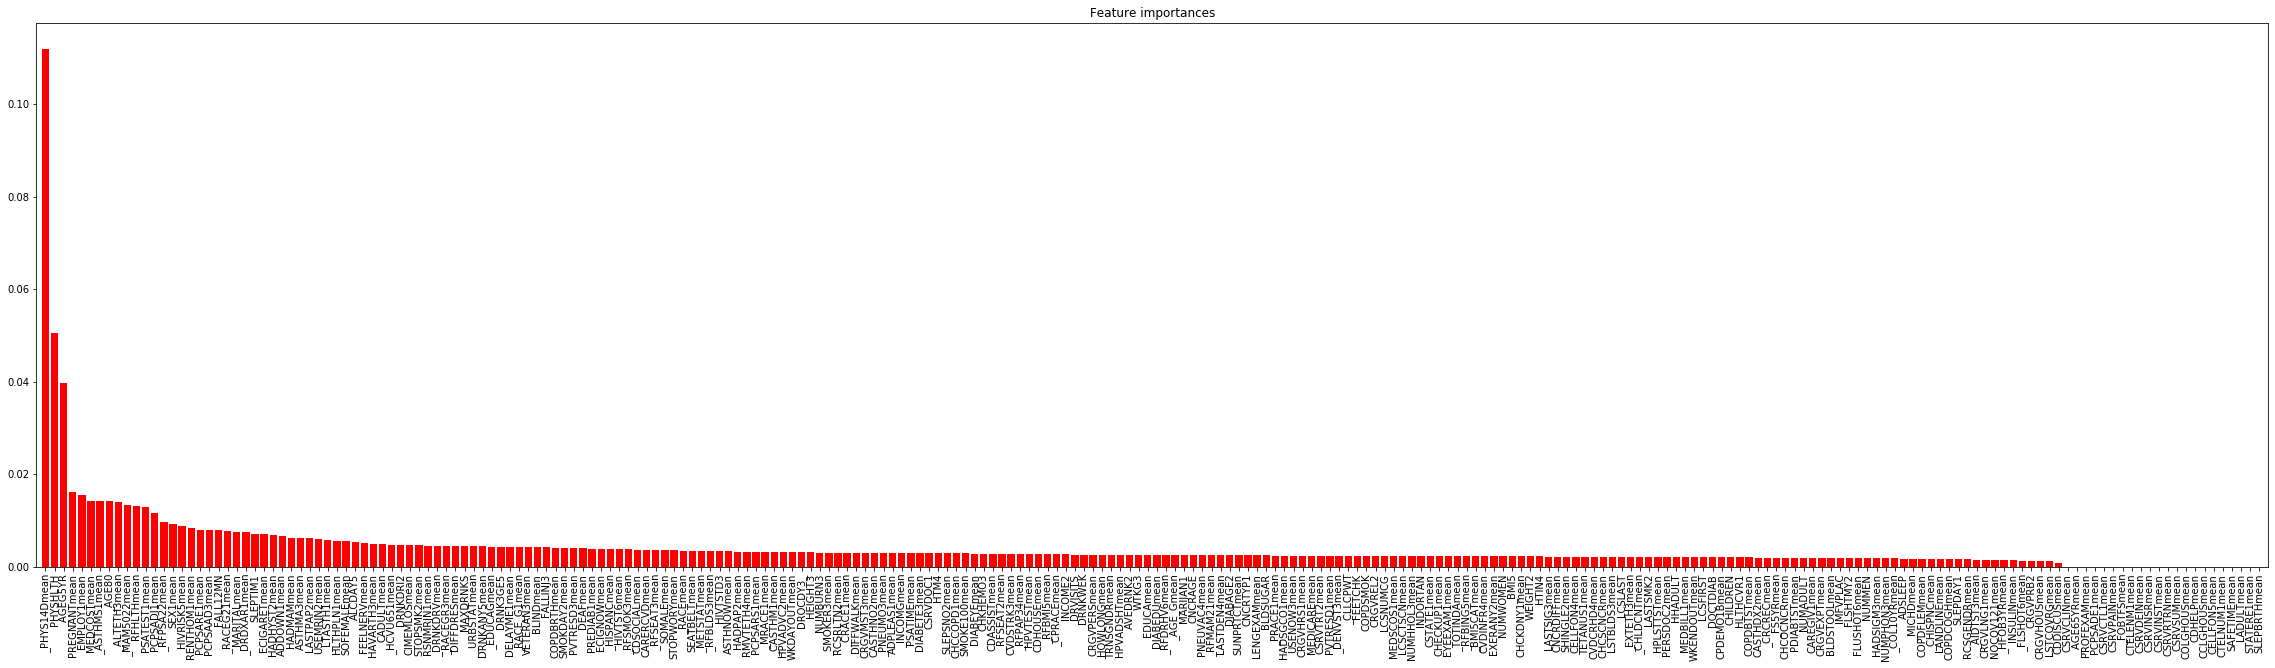

The most important 10 variables: ['_PHYS14Dmean' 'PHYSHLTH' '_AGEG5YR' 'PREGNANTmean' 'EMPLOY1mean'
 'MEDCOSTmean' '_ASTHMS1mean' '_AGE80' '_ALTETH3mean' '_MAM5022mean']


In [68]:
importances = gb_clf.feature_importances_

#for i in range(len(df.columns)):
#    print(np.sort(df.columns)[i])
#    print(np.sort(df_record['SASVariableName'])[i])
#  FEETCHK3 PCDMDEC1 These two variables are missing in the description
indices = np.argsort(importances)[::-1]
feature_list = [X_train.columns[indices[f]] for f in range(X.shape[1])]  #names of features.
ff = np.array(feature_list)
# Plot the feature importances of the forest
plt.figure()
plt.rcParams['figure.figsize'] = [40, 6]
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), ff, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()
print('The most important 10 variables:',ff[:10])

### Examine the question details of the top5 variables

In [106]:

for vn in ff[0:5]:
    print(df_record['Label'][
    np.where([i.lstrip(' ').rstrip(' ')==str.split(vn,'mean')[0]  for i in df_record['SASVariableName']])[0][0]
    ])
    print(df_record['Question'][
    np.where([i.lstrip(' ').rstrip(' ')==str.split(vn,'mean')[0]  for i in df_record['SASVariableName']])[0][0]
    ])
    print(' ')

Computed Physical Health Status 
 3 level not good physical health status: 0 days, 1-13 days, 14-30 days
 
Number of Days Physical Health Not Good
	Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?
 
Reported age in five-year age categories calculated variable
  Fourteen-level age category
 
Pregnancy Status 
  To your knowledge, are you now pregnant?
 
Employment Status 
  Are you currently…?
 
